## Introduction

Washington State University's Decision Aid System as well as others have provided tree fruit growers with population phenology models for the common pest known as codling moth (_Cydia pomonella_) for years which have been shown to be quite reliable, and much research has been done into the population dynamics of codling moth subject to the manipulation various independent variables. One inconsistency relayed to the WSU CAHNRS Dept. of Entomology by growers is a discrepancy in the time our models expect the first emergences of the overwintering generation, and when their traps actually find evidence of them. Some organizations have asserted that these first trap captures are indicitive of the _real_ first emergence times, stating that they should be used as a sort of "biofix" that the models must be translated over to match. The fact that the same growers report significantly better matching in the second and third generations suggests to us that this is not the case, and we hypothesize that it is the result of sampling error that causes the difference in time between first emergence and first capture in these systems. Due to the very monolithic management of real orchards making field data not useful, and the very long turnaround times for new lab data to become available, it has been opted to use a simulation generating data matching key expectations gathered in previous lab studies to investigate the problem. The simulation is used to generate a swathe of data as a convolution of three varying degrees of freedom in the starting conditions (starting population size of the overwintering generation, percentage chance to capture a moth on a given degree day, and the average mating delay experienced by the moths).

## Import libraries and split into individual dataframes for each permutation of variables

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
df = pd.read_csv('test_1.csv')
dfs = np.array_split(df, len(df)/df.dd_span.head(1).iloc[0])

In [2]:
dfs[0].head()

,dd,pop_captured_0,pop_captured_1,pop_captured_2,pop_active_0,pop_active_1,pop_active_2,pop_emerged_0,pop_emerged_1,pop_emerged_2,eggs_0,eggs_1,eggs_2,eggs_total_0,eggs_total_1,eggs_total_2,pop_0,prob_capture,mating_delay,dd_span
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1000.0,0.0,0.0,1000,0.0,0.0,1000,0.01,0,2201
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1000.0,0.0,0.0,1000,0.0,0.0,1000,0.01,0,2201
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1000.0,0.0,0.0,1000,0.0,0.0,1000,0.01,0,2201
3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1000.0,0.0,0.0,1000,0.0,0.0,1000,0.01,0,2201
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1000.0,0.0,0.0,1000,0.0,0.0,1000,0.01,0,2201


## Compile data about capture-emergence difference and clean instances with no first generation captures and/or first generation emergences

In [3]:
def compile_diffs(dfs, thresh: int):
    capture_data = []
    for frame in dfs:
        first_capture = frame[frame.pop_captured_0 > thresh].head(1).dd
        first_emergence = frame[(frame.pop_emerged_0 > thresh)].head(1).dd
        if not first_capture.empty and not first_emergence.empty:
            diff = first_capture.iloc[0] - first_emergence.iloc[0]
            pop_0 = frame.head(1).pop_0.iloc[0]
            prob_capture = frame.head(1).prob_capture.iloc[0]
            mating_delay = frame.head(1).mating_delay.iloc[0]
            ratio_naive = pop_0 * prob_capture
            ratio = (pop_0 ** 1/3) * (prob_capture ** 3)
            capture_data.append((diff, ratio, ratio_naive, pop_0, prob_capture, mating_delay))
    return capture_data

first_capture_data = compile_diffs(dfs, 1)

Two ratios are generated here for combinations between overwintering pop size and capture probability, a naive ratio just by multiplying them together (yes, I know this technically isn't a ratio since it's not divison, but since one of these values is very big and the other very small, multiplying gives much nicer numbers and is no less valid as a combination of the two than if I chose to multiply), and a better ratio by multiplying the cube root of the population to the cube of the capture probability. This balances out their relative importance in determining the difference much better, as will be demonstrated.

## Organize data into three dataframes, a unified frame, an explanitory varaible frame, and a dependent variable frame

In [4]:
capture_df = pd.DataFrame(first_capture_data, columns=['difference', 'ratio', 'naive_ratio', 'pop_0', 'prob_capture', 'mating_delay'])
df_x = capture_df.drop('difference', axis=1)
df_y = capture_df['difference']

## View variables against each other

<Axes: xlabel='mating_delay', ylabel='difference'>

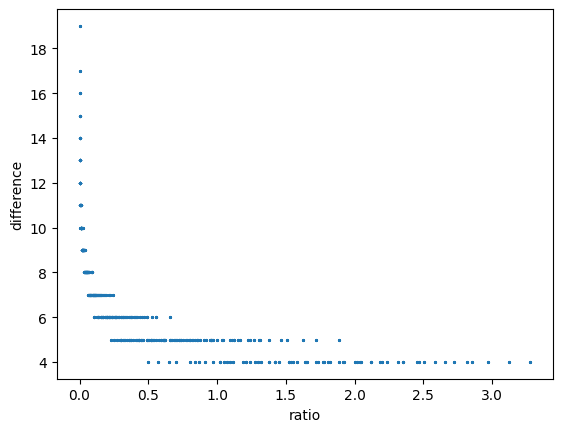

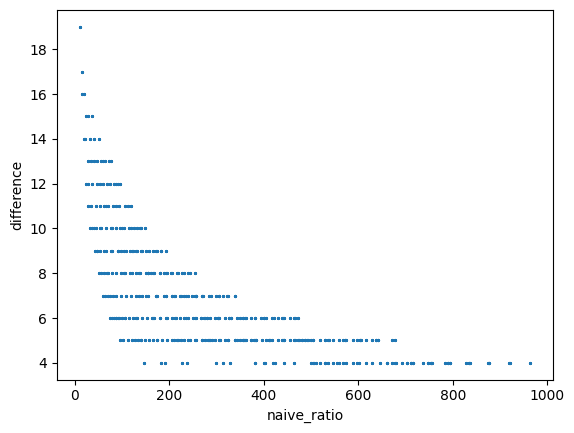

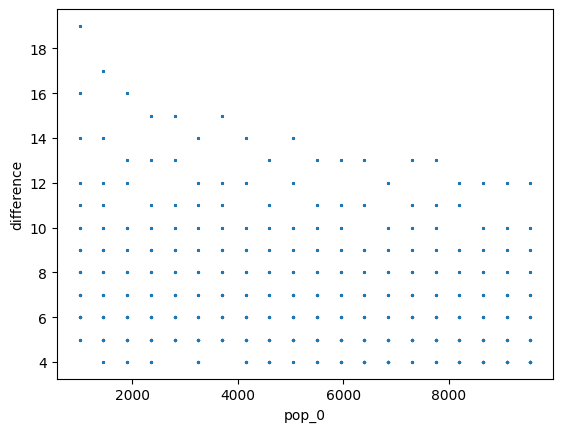

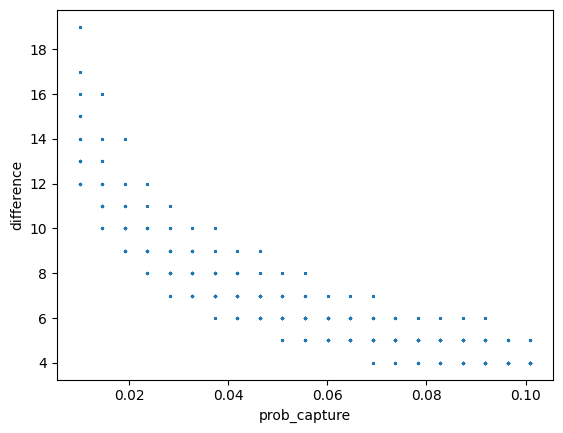

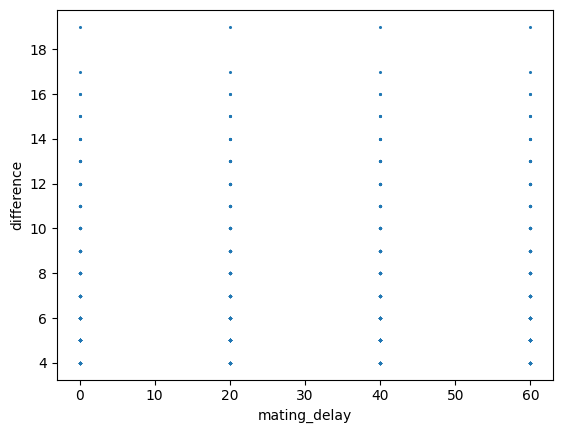

In [5]:
is_log = False
capture_df.plot.scatter(1, 0, 1.5, loglog=is_log)
capture_df.plot.scatter(2, 0, 1.5, loglog=is_log)
capture_df.plot.scatter(3, 0, 1.5, loglog=is_log)
capture_df.plot.scatter(4, 0, 1.5, loglog=is_log)
capture_df.plot.scatter(5, 0, 1.5, loglog=is_log)

## Create function for automatically fitting reciprocal functions using inverse-composition linearization

In [6]:
def autofit_reciprocal(x, y, a_guess, b_guess, c_guess, full_output=False):
    a = a_guess
    b = b_guess
    c = c_guess
    slope = 2
    intercept = 1

    # fit 'b' parameter
    magnitude = 1
    for _ in range(1,50):
        y_linear = np.power(np.multiply(np.reciprocal(np.subtract(y, b)), a), 1 / c)
        p = np.polyfit(x, y_linear, 1, w=np.log(y))
        b_below = b + (0.1 ** magnitude)
        b_above = b - (0.1 ** magnitude)
        y_linear_above = np.power(np.multiply(np.reciprocal(np.subtract(y, b_above)), a), 1 / c)
        y_linear_below = np.power(np.multiply(np.reciprocal(np.subtract(y, b_below)), a), 1 / c)
        p_above = np.polyfit(x, y_linear_above, 1, w=np.log(y))
        p_below = np.polyfit(x, y_linear_below, 1, w=np.log(y))
        if abs(p[1]) < abs(p_above[1]) and abs(p[1]) < abs(p_below[1]):
            magnitude = magnitude + 1
        elif abs(p_above[1]) < abs(p_below[1]):
            b = b_above
        elif abs(p_below[1]) < abs(p_above[1]):
            b = b_below

    # fit 'a' parameter
    magnitude = 0
    for _ in range(1,50):
        y_linear = np.power(np.multiply(np.reciprocal(np.subtract(y, b)), a), 1 / c)
        p = np.polyfit(x, y_linear, 1, w=np.log(y))
        a_below = a + (0.1 ** magnitude)
        a_above = a - (0.1 ** magnitude)
        y_linear_above = np.power(np.multiply(np.reciprocal(np.subtract(y, b)), a_above), 1 / c)
        y_linear_below = np.power(np.multiply(np.reciprocal(np.subtract(y, b)), a_below), 1 / c)
        p_above = np.polyfit(x, y_linear_above, 1, w=np.log(y))
        p_below = np.polyfit(x, y_linear_below, 1, w=np.log(y))
        # print(f'{a}, {p_above[0]}, {p[0]}, {p_below[0]}')
        if abs(p[0] - 1) < abs(p_above[0] - 1) and abs(p[0] - 1) < abs(p_below[0] - 1):
            magnitude = magnitude + 1
        elif abs(p_above[0] - 1) < abs(p_below[0] - 1):
            a = a_above
        elif abs(p_below[0] - 1) < abs(p_above[0] - 1):
            a = a_below
    if full_output:
        return (a, b, p)
    else:
        return (a, b)

## Fit curve to data using naive ratio

0.999996876200253 -3.005990248565872e-13


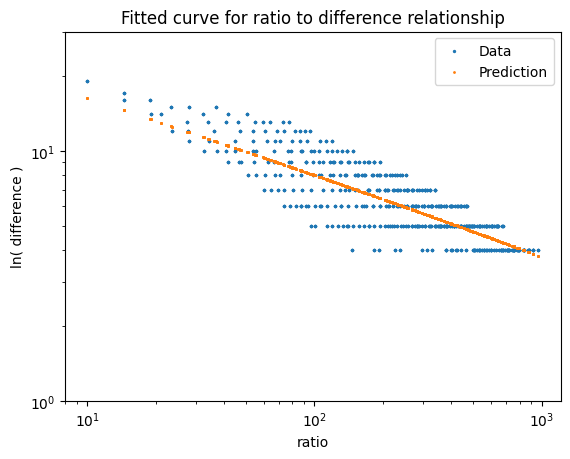

In [7]:
x = capture_df.naive_ratio
y = capture_df.difference

c = 0.29
a, b, p = autofit_reciprocal(x, y, 3, 0.3, c, full_output=True)
print(*p)

y_linear_naive = np.power(np.multiply(np.reciprocal(np.subtract(y, b)), a), 1 / c)

fitted_x = np.linspace(x.min(), x.max(),1000)
fitted_y_naive = np.add(np.multiply(np.reciprocal(np.power(x, c)), a), b)

ax = plt.axes()
ax.scatter(x, y, label='Data', s=2)
ax.scatter(x, fitted_y_naive, label='Prediction', s=1)
ax.set_title('Fitted curve for ratio to difference relationship')
ax.set_ylabel('ln( difference )')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(1, 30)
ax.set_xlabel('ratio')
ax.legend()

## Check residuals

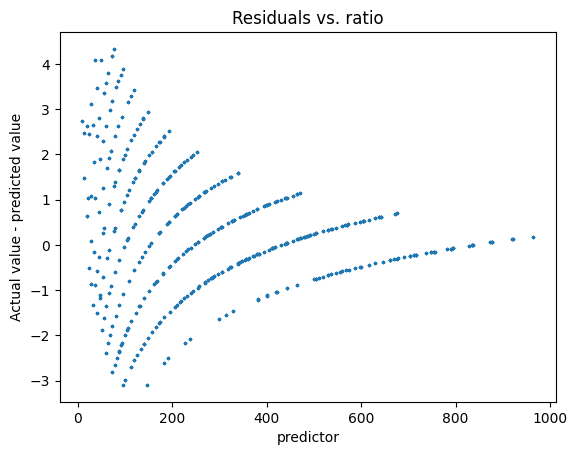

In [8]:
from scipy.stats import zscore

def residual_plot(x, y, fitted_y, log=False):
    data = {'ratio': x, 'residual':np.subtract(y, fitted_y)}
    residuals = pd.DataFrame(data)
    #residuals = residuals[(np.abs(zscore(residuals.residual)) < 4)]
    ax = plt.axes()
    ax.scatter(residuals.ratio, residuals.residual, label='Data', s=2)
    ax.set_title('Residuals vs. ratio')
    ax.set_ylabel('Actual value - predicted value')
    ax.set_xlabel('predictor')
    if log:    
        ax.set_yscale('log')
        ax.set_xscale('log')

residual_plot(x, y, fitted_y_naive)

heteroscedasticity could definitely be improved

## Fit curve to data using smarter ratio

(3.660890776116469, 0.8979282714661776)


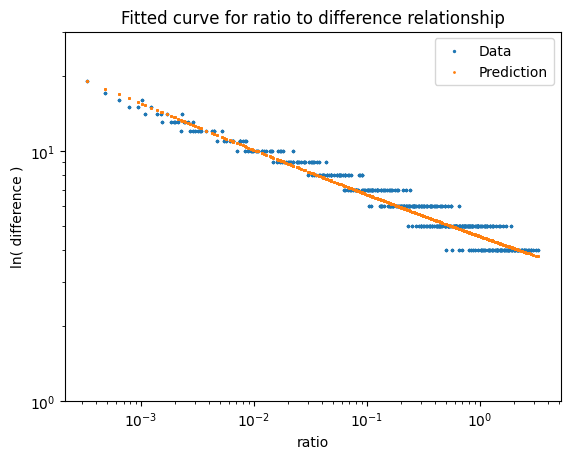

In [9]:
x = capture_df.ratio
y = capture_df.difference

c = 0.2
a, b = autofit_reciprocal(x, y, 3, 0.7, c)

y_linear = np.power(np.multiply(np.reciprocal(np.subtract(y, b)), a), 1 / c)

fitted_x = np.linspace(x.min(), x.max(),1000)
fitted_y = np.add(np.multiply(np.reciprocal(np.power(x, c)), a), b)

ax = plt.axes()
ax.scatter(x, y, label='Data', s=2)
ax.scatter(x, fitted_y, label='Prediction', s=1)
ax.set_title('Fitted curve for ratio to difference relationship')
ax.set_ylabel('ln( difference )')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(1, 30)
ax.set_xlabel('ratio')
ax.legend()
print((a, b))

For the ratio function of (pop_0^1/3) * (prob_capture^3), a function of y = (3.024 / x ^ 0.2) + 0.965 predicts the difference in first emergence and first capture.

## Determine goodness of fit by looking at residuals

### Residual Plot

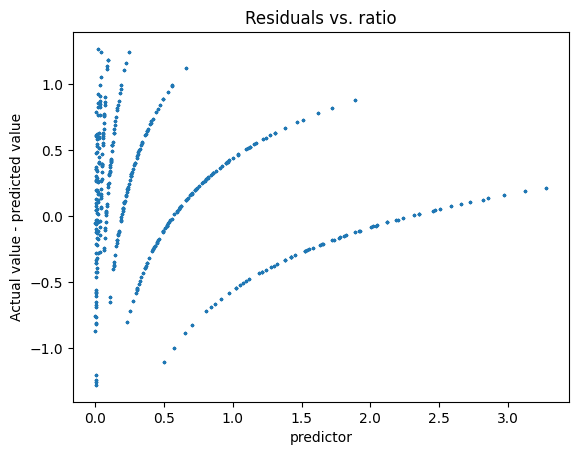

In [10]:
residual_plot(x, y, fitted_y)

Definitely still some heteroscedasticity, but it looks like the worst of it is only +/- 1. Measureable improvement from the naive ratio. Furthermore, from looking at the fitted curve graphs of the two, no value of 'c' was able to match both the extreme and median points to a satisfactory degree with the naive ratio, but a 'c' of 0.2 matches both quite well with the smarter combination

### Average bias per point

In [11]:
np.sum(np.subtract(y, fitted_y)) / len(x)

0.14099709146460362

The fitted curve is a little biased relative to the actual data, but I again feel that less than a fifth of a degree day average negative bias is satisfactory for practical use.

## At this point I decide to rethink which parameter I want to base the model off of

My rationale is this: One of the biggest issues I'm facing in making this model is the extreme instability around small ratio values, and if you look at the difference vs predictor graphs I have towards the top, you can visually see that it is mostly the fault of the "size of the overwintering population" (pop_0) to blame for this. Furthermore, this parameter would be _very_ difficult to get an actual read on in the field. Furthermore, if I do analysis on the sampling effort with a constant population, then that allows me to trivially apply these differences to the known phenology curves, which are in proportions of total population and not integer moth counts. If the population is kept constant through the first generation, just multiply the phenology curves by that constant number to apply the differences, and then divide again to get back to proportions. The capture probability parameter is both more uniformly stable around small values, and also is actually feasible to estimate in real world situations, so I'm going to generate a new data set, holding both mating delay and pop_0 constant, so as to get a direct look at the effect of the per degree day capture probability with significantly higher resolution. I also had to modify the data output from the simulation to get an integrated energence value, as the current system for using the population active works explicitly only for the first emergence, as any past that are subject to death and capture diminishing the true number of emergences.

## Build DataFrames for the new focused set

In [12]:
df = pd.read_csv('test_2.csv')
dfs = np.array_split(df, len(df)/df.dd_span.head(1).iloc[0])

## Investigate also how the difference evolves when looking at second captures, third captures, etc.

### Compile 1st through 90th differences

In [52]:
diffs = []
for i in range(1,300):
    row = compile_diffs(dfs, i)
    row_df = pd.DataFrame(row, columns=['difference', 'ratio', 'naive_ratio', 'pop_0', 'prob_capture', 'mating_delay'])
    diffs.append(row_df)

len(diffs)

299

### Look at the graphs of the first, second, third, fifth, tenth, and fiftheenth differences against the probability of capture

<Axes: title={'center': 'Fifteenth diffs'}, xlabel='prob_capture', ylabel='difference'>

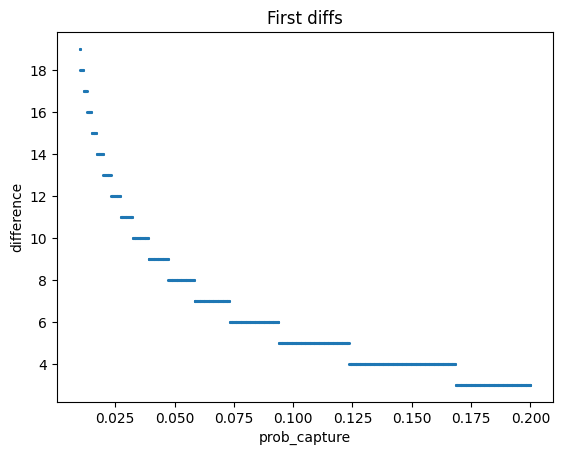

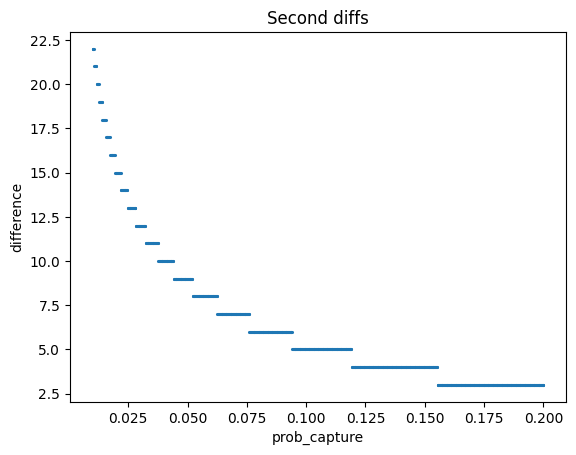

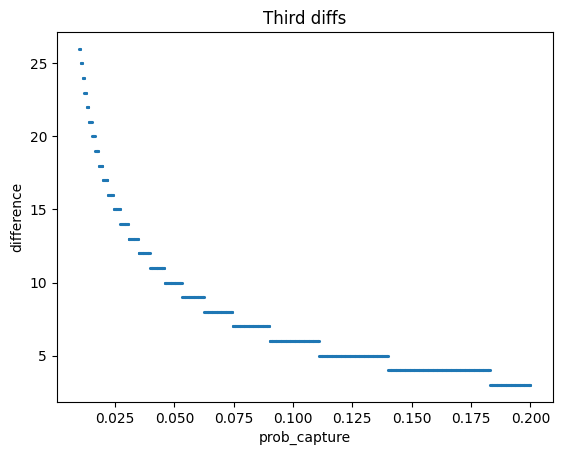

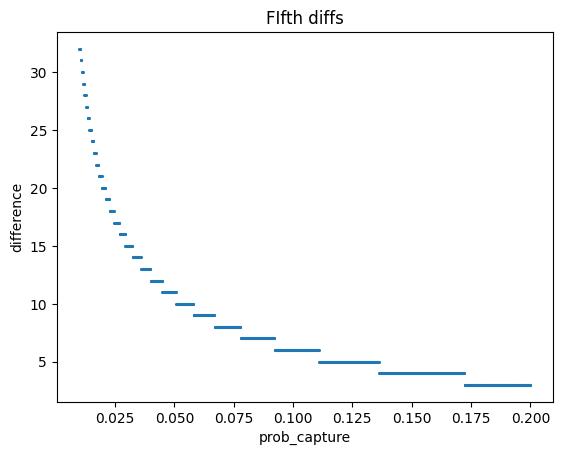

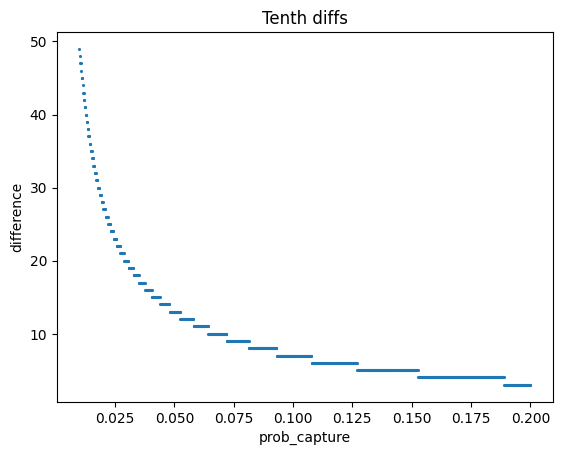

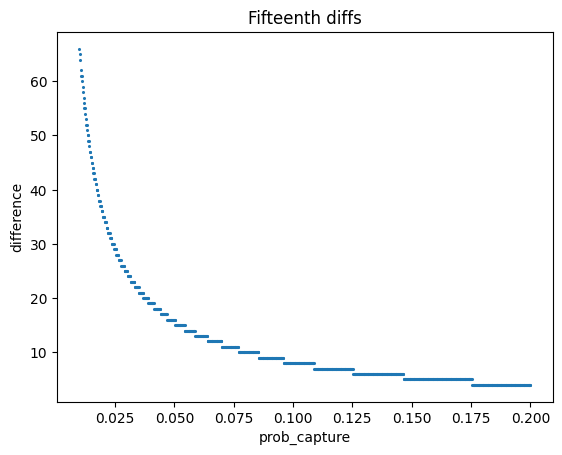

In [14]:
is_log = False
diffs[0].plot.scatter(4, 0, 1.5, title='First diffs', loglog=is_log)
diffs[1].plot.scatter(4, 0, 1.5, title='Second diffs', loglog=is_log)
diffs[2].plot.scatter(4, 0, 1.5, title='Third diffs', loglog=is_log)
diffs[4].plot.scatter(4, 0, 1.5, title='FIfth diffs', loglog=is_log)
diffs[9].plot.scatter(4, 0, 1.5, title='Tenth diffs', loglog=is_log)
diffs[14].plot.scatter(4, 0, 1.5, title='Fifteenth diffs', loglog=is_log)

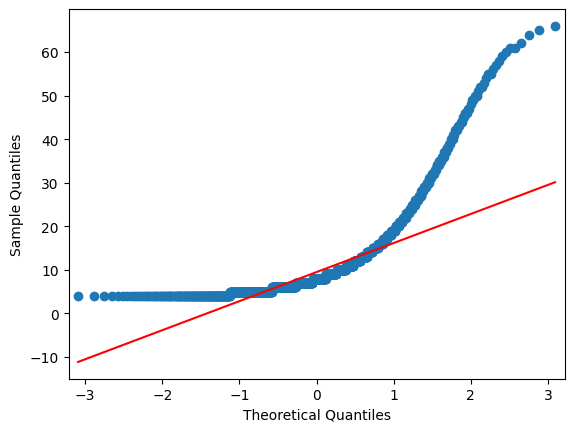

In [15]:
from statsmodels.api import qqplot
_ = qqplot(diffs[14].difference, line='q')

## Make a better fitting function for the more well behaved data

In [16]:
import statsmodels.formula.api as smf

def new_autofit(x, y, residuals=False, full_output=False):
    data = pd.DataFrame({'difference':y, 'prob_capture':x})
    model = smf.ols('np.log(difference) ~ np.log(prob_capture)', data=data).fit()
    if full_output:
        print(model.summary())
    if residuals:
        return (model.params[1], np.exp(model.params[0]), model.resid)
    return (model.params[1], np.exp(model.params[0]))


                            OLS Regression Results                            
Dep. Variable:     np.log(difference)   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                 8.567e+04
Date:                Tue, 31 Oct 2023   Prob (F-statistic):               0.00
Time:                        13:10:57   Log-Likelihood:                 1216.1
No. Observations:                1001   AIC:                            -2428.
Df Residuals:                     999   BIC:                            -2418.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.2370 

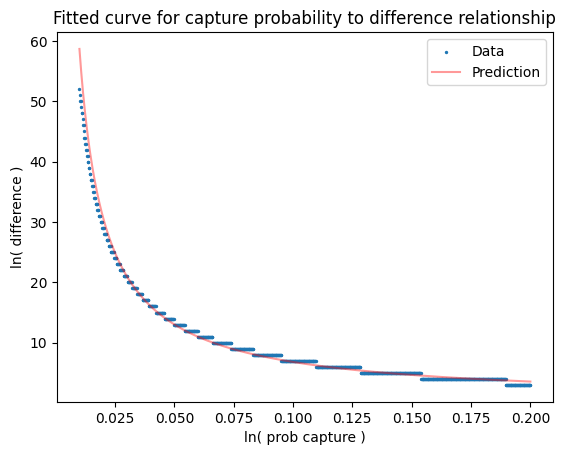

In [17]:
n = 10
x = diffs[n].prob_capture
y = diffs[n].difference

a, b, resid = new_autofit(x, y, residuals=True, full_output=True)

fitted_x = np.linspace(x.min(), x.max(), len(y))
fitted_y = np.multiply(np.power(x,a), b)

ax = plt.axes()
ax.scatter(x, y, label='Data', s=2)
ax.plot(x, fitted_y, label='Prediction', alpha=0.4, color='red')
ax.set_title('Fitted curve for capture probability to difference relationship')
ax.set_ylabel('ln( difference )')
#ax.set_yscale('log')
#ax.set_xscale('log')
ax.set_xlabel('ln( prob capture )')
ax.legend()

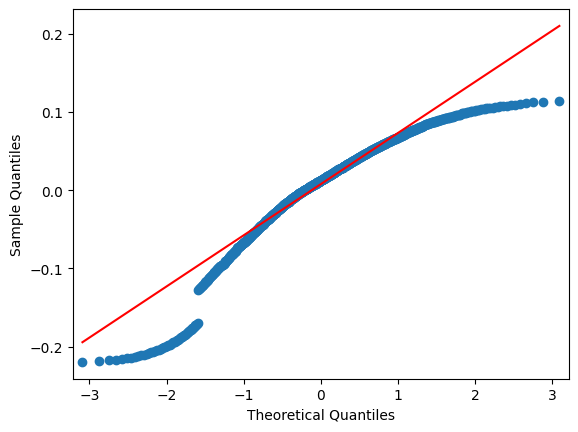

In [18]:
_ = qqplot(resid, line='q')

These residuals aren't perfect but I believe they are well within the realm of acceptability

### Model the change in models!

1.1972837726296297


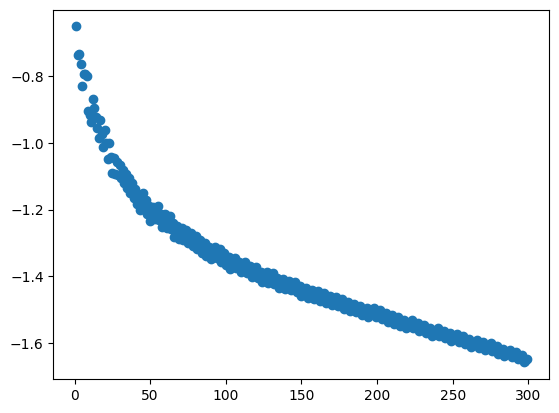

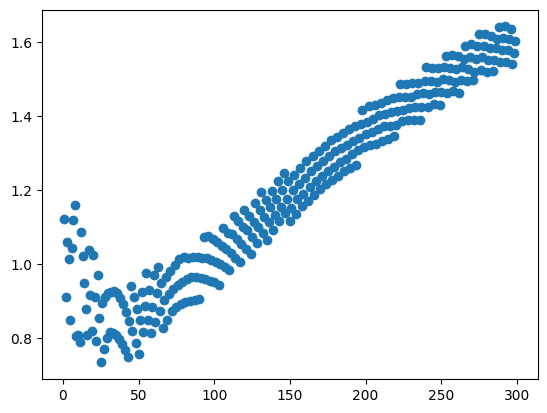

In [53]:
model_mat = []
for diff in diffs:
    a, b = new_autofit(diff.prob_capture, diff.difference)
    model_mat.append((a,b))
    
a = np.array(model_mat).T[0]
a = -a
b = np.array(model_mat).T[1]
x = np.arange(1,len(diffs)+1)

print(np.mean(b))

plt.scatter(x, -a)
#plt.xscale('log')
#plt.yscale('log')
plt.show()
plt.scatter(x, b)
#plt.xscale('log')
#plt.yscale('log')
plt.show()

                            OLS Regression Results                            
Dep. Variable:          np.log(power)   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                 3.423e+04
Date:                Tue, 31 Oct 2023   Prob (F-statistic):          8.85e-309
Time:                        13:19:39   Log-Likelihood:                 816.67
No. Observations:                 299   AIC:                            -1629.
Df Residuals:                     297   BIC:                            -1622.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.5111      0.005   -111.

(0.175556141779533, 0.5998490847161748)

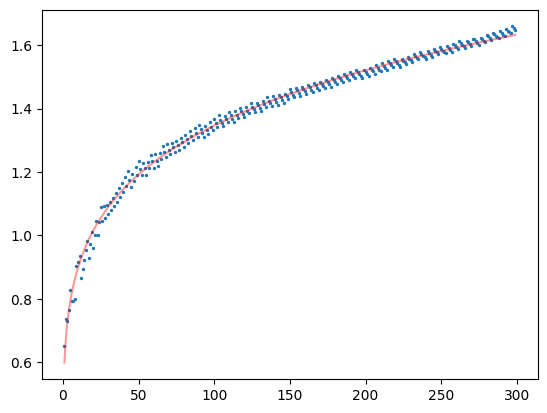

In [54]:
data = pd.DataFrame({'power':a, 'n_diff':x})
model = smf.ols('np.log(power) ~ np.log(n_diff)', data=data).fit()
a_a = model.params[1]
a_b = np.exp(model.params[0])
y_fitted = np.multiply(np.power(x,a_a), a_b)
print(model.summary())
ax = plt.axes()
ax.scatter(x, a, label='Data', s=2)
ax.plot(x, y_fitted, label='Prediction', alpha=0.4, color='red')
(a_a, a_b)

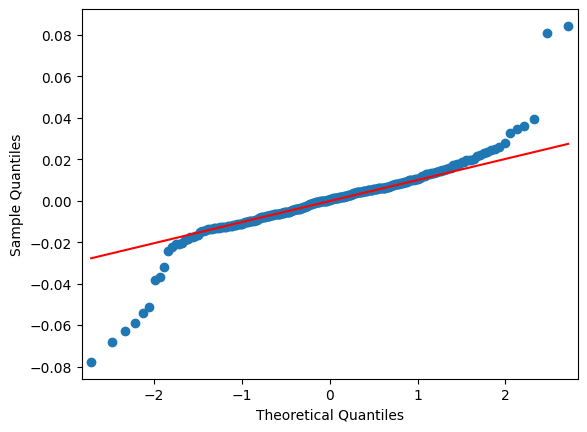

In [55]:
_ = qqplot(model.resid, line='q')

                            OLS Regression Results                            
Dep. Variable:                   coef   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.914
Method:                 Least Squares   F-statistic:                     3177.
Date:                Tue, 31 Oct 2023   Prob (F-statistic):          1.21e-160
Time:                        13:24:59   Log-Likelihood:                 355.79
No. Observations:                 299   AIC:                            -707.6
Df Residuals:                     297   BIC:                            -700.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7789      0.009     90.939      0.0

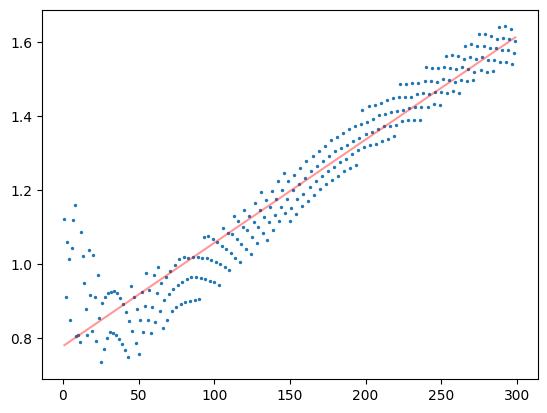

In [60]:
data = pd.DataFrame({'coef':b, 'n_diff':x})
model = smf.ols('coef ~ n_diff', data=data).fit()
print(model.summary())
y_fitted = model.params[1]*x + model.params[0]
ax = plt.axes()
ax.scatter(x, b, label='Data', s=2)
ax.plot(x, y_fitted, label='Prediction', alpha=0.4, color='red')

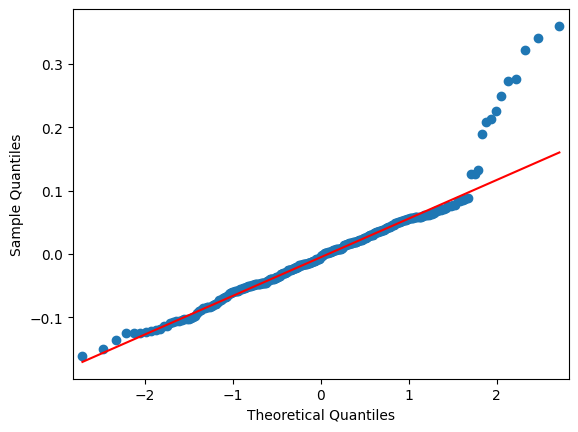

In [57]:
_ = qqplot(model.resid, line='q')

The model for the exponent of the power law is REALLY good, the residuals show that the true distribution may have *ever so slightly* heavier tails than the fitted model, but with such low variance thats something that is totally fine by me.  
The model for the coefficient isn't exactly a perfect fit, but it contributes so little to the overall model that I don't think it's worth the added complexity of making it better. Additionally it would require looking into more data than I already have here, so it's not worth the labor.

### Shifting emergence data to meet capture data

In [682]:
from scipy.stats import johnsonsb

def capture_delay(effort, n):
    a = -((0.601)*(n**(0.175)))
    b = 0.7789 + (0.0028*n)
    return b*(effort**a)
def jw_emergence(dd, max):
    gamma = 1.0737
    delta = 1.2349
    llambda = 577.2
    zeta = 69.0
    return max * johnsonsb.cdf(dd, gamma, delta, loc=zeta, scale=llambda)
def inv_jw_emergence(moths, max):
    gamma = 1.0737
    delta = 1.2349
    llambda = 577.2
    zeta = 69.0
    return johnsonsb.ppf((moths/max), gamma, delta, loc=zeta, scale=llambda)
def capture_prediction(dd, effort, max):
    return jw_emergence(dd - capture_delay(effort,jw_emergence(dd, max)), max)

0.01019

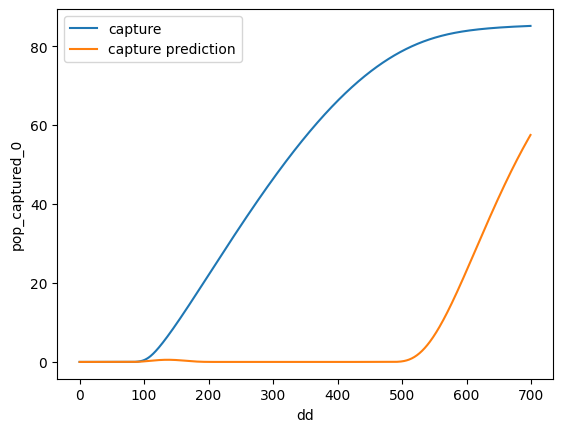

In [696]:
import seaborn as sns
shift_data = dfs[1]
x = shift_data.dd
y_emerge = shift_data.pop_emerged_0
y_capture = shift_data.pop_captured_0
effort = shift_data.head(1).prob_capture.item()
max_time = 700
#ax = sns.lineplot(x=x[0:max_time], y=y_emerge[0:max_time], label='emergence')
ax.set(xlabel='degree days', ylabel='moths')
ax = sns.lineplot(x=x[0:max_time], y=y_capture[0:max_time], label='capture')
y_max = y_capture.max()
adj_y = capture_prediction(x, effort, y_max)
ax = sns.lineplot(x=x[0:max_time], y=adj_y[0:max_time], label='capture prediction')
effort

I'm not liking how the model constantly underestimates things, I think we can try fitting the exponent for the _a_ parameter on the performance of this shifting instead of on _n_

### better parameters by fitting to the whole-season predictions

In [697]:
def capture_delay(effort, n):
    a = -((0.601)*(n**(0.1)))
    b = 0.7789 + (0.0028*n)
    return b*(effort**a)

In [698]:
def shift_error_new(delay_func):
    difference = 0
    for i in range(500):
        shift_data = dfs[i*2]
        x = shift_data.dd
        y_emerge = shift_data.pop_emerged_0
        y_capture = shift_data.pop_captured_0
        effort = shift_data.head(1).prob_capture.item()
        y_max = y_capture.max()
        adj_y = jw_emergence(x - delay_func(effort,x), y_max)
        difference += np.sum([np.abs((y_capture.iloc[dd]-adj_y[dd])/y_max) for dd in x])
    return difference
coef_b = 0.0028
def fit_a(seed):
    error = shift_error_new(capture_delay)
    coef = seed
    for i in range(20):
        def capture_delay_new(effort, n):
            a = -((0.601)*(n**(coef)))
            b = 0.7789 + (coef_b*n)
            return b*(effort**a)
        error_new = shift_error_new(capture_delay_new)
        error_quotient = error_new / error
        print(f'{error}, {error_new}, {error_quotient}, {coef}')
        coef = error_quotient * coef
        error = error_new
        if error_quotient.round(3) == 1.00:
            break
    return coef
coef = fit_a(0.09)
coef

19846.35446839633, 7474.476844047091, 0.3766171190759277, 0.09
7474.476844047091, 5973.37272194712, 0.7991693394173136, 0.03389554071683349
5973.37272194712, 6201.047579555431, 1.0381149592041692, 0.027088276883864476
6201.047579555431, 6167.6320894862765, 0.9946113153236682, 0.02812074545220421
6167.6320894862765, 6172.562377398944, 1.000799381000866, 0.02796921162209889
6172.562377398944, 6171.835588583667, 0.9998822549257764, 0.027991569678478795


0.02798827380902937

In [699]:
def capture_delay(effort, n):
    a = -((0.601)*(n**(coef)))
    b = 0.7789 + (coef_b*n)
    return b*(effort**a)

In [700]:
def fit_b(seed):
    error = shift_error_new(capture_delay)
    coef_b = seed
    for i in range(30):
        def capture_delay_new(effort, n):
            a = -((0.601)*(n**(coef)))
            b = 0.7789 + (coef_b*n)
            return b*(effort**a)
        error_new = shift_error_new(capture_delay_new)
        error_quotient = error_new / error
        print(f'{error}, {error_new}, {error_quotient}')
        coef_b = error_quotient * coef_b
        error = error_new
        if error_quotient.round(2) == 1.00:
            break
    return coef_b
coef_b = fit_b(0.01)
coef_b

6171.942746954751, 4190.250136560671, 0.6789191520981217
4190.250136560671, 4323.972873230825, 1.0319128291419644
4323.972873230825, 4263.902866634976, 0.9861076819034331
4263.902866634976, 4290.099015897824, 1.0061437021625967
4290.099015897824, 4278.514744250807, 0.997299765901885


0.006932200961134701

In [702]:
def capture_delay(effort, n):
    a = -((0.601)*(n**(coef)))
    b = 0.7789 + (coef_b*n)
    return b*(effort**a)
#shift_error_new(capture_delay)

Pulling the analysis together, the simulated data predicts that, assuming there is a starting overwintering population size of 1,000, the equation that relates difference and sampling effort is the following:
$$ f(x,n) = \hat{y} = bx^a + \epsilon $$
where:
$$\begin{flalign} a &= -(0.601)n^{0.027} \\
b &= 0.7789 + 0.0066n \\
x &= \textrm{ percentage change to capture one moth over one degree day (sampling effort) } \\
\hat{y} &= \textrm{ difference in degree days between the emergence of the n-th moth and capture of n moths} \\
\epsilon &= \textrm{ model error and noise } \end{flalign}$$

Because the population was kept constant (1,000) for the simulation data set involved in this section of the analysis, the method of application to the phenology curves just involves multiplying the phenology curve by 1,000, choosing points in the curve where $y = n$, and adding the value of $f(x,n)$ to the degree day value for the phenology curve where $y=n$. The idea is to do this for a range of $n$, then use the resulting shifted points to fit a new, flatter Johnson SB distribution, which is the predicted field curve under a given sampling effort. Even though the concrete unit for sampling effort for this equation is 'percentage change to capture a moth in a single degree day under the conditions of the simulation', other units of sampling effort (such as trap number or trap density) could be investigated for conversion factors to this rather arbitrary unit by analysis of field data.  
One last thing to consider is the fact that there will be a vertical compression of the observed capture curve due to moths dying before they're able to be captured.

## Analysis of Field Data

### Data prep and looks at dd~diff slices

In [28]:
oksir = pd.read_csv('region_A1a.csv')
oksir.head()

,Unnamed: 0,X,Y,Date,julian,Wild,Year
0,1,-119.580568,49.126713,2015-04-13,103,0.0,2015
1,2,-119.581150,49.127490,2015-04-13,103,0.0,2015
2,3,-119.581465,49.128551,2015-04-13,103,0.0,2015
3,4,-119.578896,49.128906,2015-04-13,103,0.0,2015
4,5,-119.579639,49.131926,2015-04-13,103,0.0,2015


In [29]:
years = oksir.Year.unique()
oksir_year = {}
for year in years:
    oksir_year[year] = oksir[oksir['Year'] == year]
oksir_year[2015].head()

,Unnamed: 0,X,Y,Date,julian,Wild,Year
0,1,-119.580568,49.126713,2015-04-13,103,0.0,2015
1,2,-119.581150,49.127490,2015-04-13,103,0.0,2015
2,3,-119.581465,49.128551,2015-04-13,103,0.0,2015
3,4,-119.578896,49.128906,2015-04-13,103,0.0,2015
4,5,-119.579639,49.131926,2015-04-13,103,0.0,2015


In [30]:
def num_traps(data):
    return len(data.X.unique())

At this point I realize that I need to combine this very granular dataset with an integrated one I also have. Only issue is that it doesn't have year information. I need to use the first date and the first capture date to match them together.

In [31]:
years

array([2015, 2014, 2004, 1998, 2009, 2001, 2007, 2013, 2000, 2002, 1995,
       1996, 1999, 2006, 2008, 2010, 2005, 1997, 2012, 2011])

In [32]:
year_jul = []
for year in years:
    year_jul.append((year, \
                     oksir_year[year].head(1).julian.item(), \
                     oksir_year[year][oksir_year[year]['Wild'] > 0.9].head(1).julian.item()))
year_jul
years_table = pd.DataFrame(columns=['year','first_julian','first_capture_julian'], data=year_jul)
years_table

,year,first_julian,first_capture_julian
0,2015,103,119
1,2014,105,126
2,2004,109,116
3,1998,110,117
4,2009,110,132
5,2001,112,133
6,2007,114,120
7,2013,114,133
8,2000,115,115
9,2002,119,133


In [33]:
data_agg = pd.read_csv('region_A1a_aggregated.csv')
data_agg.head()

,Unnamed: 0,julian,moths,var,traps,pr0,DDs,trap_group
0,1,121,1.784615,11.178056,130,0.000000,198.993791,1
1,2,128,7.198473,90.452613,131,0.000000,253.448087,1
2,3,135,9.598485,122.211601,132,0.051529,328.473335,1
3,4,142,8.946970,106.020067,132,0.000000,413.464368,1
4,5,149,4.098485,32.394807,132,0.000000,527.562890,1


In [34]:
data_agg['moths_whole'] = data_agg['moths'] * data_agg['traps']
data_agg = data_agg.drop(columns=['Unnamed: 0'])

In [35]:
data_agg.head()

,julian,moths,var,traps,pr0,DDs,trap_group,moths_whole
0,121,1.784615,11.178056,130,0.000000,198.993791,1,232.0
1,128,7.198473,90.452613,131,0.000000,253.448087,1,943.0
2,135,9.598485,122.211601,132,0.051529,328.473335,1,1267.0
3,142,8.946970,106.020067,132,0.000000,413.464368,1,1181.0
4,149,4.098485,32.394807,132,0.000000,527.562890,1,541.0


In [36]:
years_table_unique = years_table.drop_duplicates(subset=['first_julian', 'first_capture_julian'], keep=False) 
group_year_lut = np.zeros(20)
for group in range(len(group_year_lut)):
    first = years_table_unique['first_julian']
    capture = years_table_unique['first_capture_julian']
    agg_grouped = data_agg[data_agg['trap_group'] == group + 1]
    agg_first = agg_grouped.head(1).julian.item()
    agg_capture = agg_grouped[agg_grouped['moths'] > 0].head(1).julian.item()
    year_table_row = years_table_unique[(first == agg_first) & (capture == agg_capture)]
    if len(year_table_row) == 0:
        group_year_lut[group] = None
    else:
        group_year_lut[group] = year_table_row.year.item()

print(group_year_lut)

[  nan   nan 1997. 1998.   nan 2000. 2001. 2002. 2004. 2005.   nan 2007.
 2008. 2009. 2010. 2011. 2012. 2013. 2014. 2015.]


In [37]:
data_agg['year'] = data_agg.trap_group.apply(lambda x: group_year_lut[x-1])
data_agg_clean = data_agg.dropna()

In [38]:
data_agg_clean.head()

,julian,moths,var,traps,pr0,DDs,trap_group,moths_whole,year
38,126,0.145078,0.176759,193,0.636875,185.932829,3,28.0,1997.0
39,133,0.589474,2.814703,190,0.000000,278.701708,3,112.0,1997.0
40,140,1.520408,13.409838,196,0.000000,378.042837,3,298.0,1997.0
41,147,0.807107,8.564643,197,0.000000,449.430991,3,159.0,1997.0
42,154,1.137056,7.098467,197,0.000000,545.636534,3,224.0,1997.0


In [39]:
# Split frame into array of frames by year
aggs = [y for x, y in data_agg_clean.groupby('year')]
aggs[0].head()

,julian,moths,var,traps,pr0,DDs,trap_group,moths_whole,year
38,126,0.145078,0.176759,193,0.636875,185.932829,3,28.0,1997.0
39,133,0.589474,2.814703,190,0.000000,278.701708,3,112.0,1997.0
40,140,1.520408,13.409838,196,0.000000,378.042837,3,298.0,1997.0
41,147,0.807107,8.564643,197,0.000000,449.430991,3,159.0,1997.0
42,154,1.137056,7.098467,197,0.000000,545.636534,3,224.0,1997.0


In [40]:
for frame in aggs:
    frame['moth_sum'] = frame['moths_whole'].cumsum()

aggs[4].head()
aggs = aggs[2:] # Inspection showed that 1997 and 1998 had consistently VERY delayed captured across the board, even compared to other years with low trap counts.
                # From this I concluded that those years had drastically low population sizes, so I've decided to get rid of them as outliers.

In [41]:
print(num_traps(oksir_year[2002]))
del aggs[2] # I don't even know what was going on with 2002. It was bouncing around like crazy, being stuck at a really low number for a long time before jumping up to being rediculously
            # larger than the others. Decided to exclude it as an outlier as well due to it's unreasonable erraticism when compared to the other points in the cohort.

123


#### Extract first differences from data

In [42]:
diffs_field = []
for i in range(25):
    acc = []
    for frame in aggs:
        first_capture_row = frame[(frame['moth_sum'] > 5*i)].head(1)
        first_emergence = inv_jw_emergence(5*i, frame.moth_sum.max())
        if len(first_capture_row) == 0:
            continue
        first_capture = first_capture_row.DDs.item()
        traps = num_traps(oksir_year[int(first_capture_row.year.item())])
        acc.append((traps, first_capture - first_emergence))
    diffs_field.append(np.array(acc).T)
diffs_field[0]

array([[396.        , 390.        , 370.        , 365.        ,
        320.        , 298.        , 271.        , 265.        ,
        262.        , 254.        , 253.        , 250.        ,
        249.        ],
       [123.47041156, 212.662073  , 176.30079665, 216.57554165,
        154.10404756,  55.48364563, 145.62099489, 141.82771364,
         76.22034197, 199.82825051, 300.88024319, 157.95241801,
        195.39448517]])

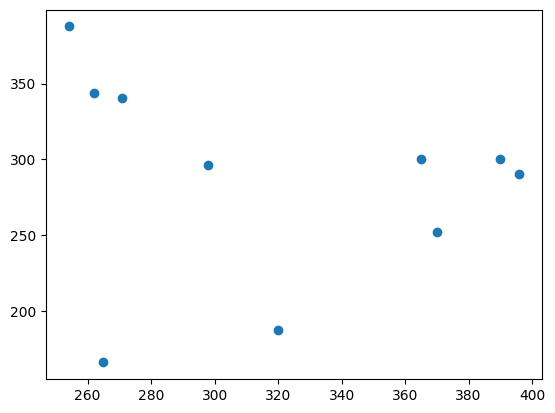

In [43]:
plt.scatter(diffs_field[20][0], diffs_field[20][1])

                            OLS Regression Results                            
Dep. Variable:     np.log(difference)   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                 -0.076
Method:                 Least Squares   F-statistic:                    0.3681
Date:                Tue, 31 Oct 2023   Prob (F-statistic):              0.561
Time:                        13:11:22   Log-Likelihood:                -7.1384
No. Observations:                  10   AIC:                             18.28
Df Residuals:                       8   BIC:                             18.88
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                6.1495 

/usr/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


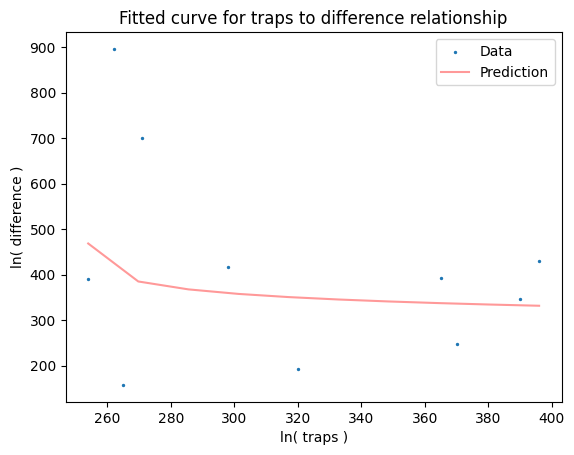

In [44]:
n = 24
x = diffs_field[n][0]
y = diffs_field[n][1]
a, b, resid = new_autofit(x-x.min()+1, y, residuals=True, full_output=True)

fitted_x = np.linspace(x.min(), x.max(), len(y))
fitted_y = np.multiply(np.power(fitted_x-x.min()+1,a), b)

ax = plt.axes()
ax.scatter(x, y, label='Data', s=2)
ax.plot(fitted_x, fitted_y, label='Prediction', alpha=0.4, color='red')
ax.set_title('Fitted curve for traps to difference relationship')
ax.set_ylabel('ln( difference )')
#ax.set_yscale('log')
#ax.set_xscale('log')
ax.set_xlabel('ln( traps )')
ax.legend()

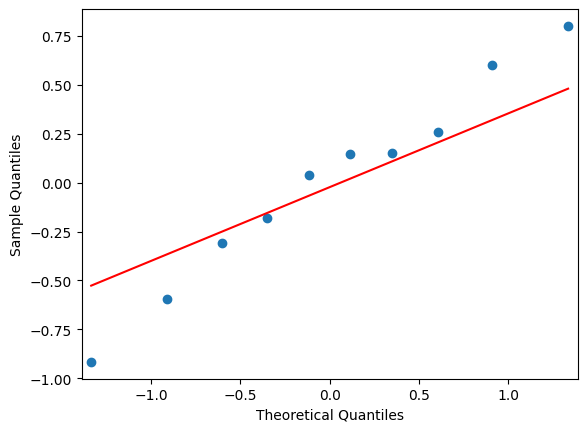

In [45]:
_ = qqplot(resid, line='q')

### Capture curve predictions on field data

<Axes: xlabel='DDs', ylabel='moth_sum'>

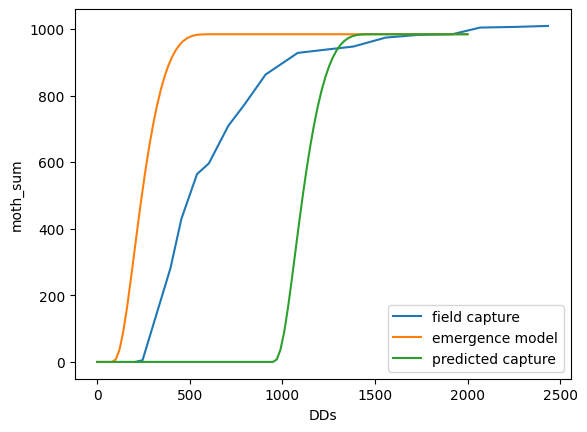

In [714]:
n = 2
phenology_x = np.linspace(0,2000, 100)
y_max = aggs[n][aggs[n].DDs < 2000].moth_sum.max()
phenology_y = [jw_emergence(x, y_max) for x in phenology_x]
#adj_x = [x + capture_delay(0.00055,jw_emergence(x, y_max)) for x in phenology_x]
adj_y = jw_emergence(phenology_x - capture_delay(0.0015,jw_emergence(phenology_x, y_max)), y_max)
sns.lineplot(data=aggs[n], x='DDs', y='moth_sum', label='field capture')
sns.lineplot(x=phenology_x, y=phenology_y, label='emergence model')
#sns.lineplot(x=adj_x, y=phenology_y, label='predicted capture')
sns.lineplot(x=phenology_x, y=adj_y, label='predicted capture')

### Make function to fit effort values

In [619]:
def field_shift_error(effort, agg):
    x = agg.DDs
    y = agg.moth_sum
    y_max = agg.moth_sum.max()
    differences = [np.power(y.iloc[i]-capture_prediction(dd, effort, y_max),2)/y_max for i, dd in enumerate(x)]
    #print(differences)
    return np.sum(differences)
  

In [626]:
efforts = []
for agg in aggs:
    agg = agg[agg.DDs < 1800]
    effort = 0.002
    effort_new = 0.001
    error = field_shift_error(effort, agg)
    print(int(agg.head(1).year.item()))
    loops = 0
    while i <= 20:
        error_new = field_shift_error(effort_new, agg)
        error_quotient = error_new / error
        #print(f'{error}, {error_new}, {error_quotient}')
        effort_new = effort_new * error_quotient
        effort = effort_new
        error = error_new
        if round(error_quotient,2) == 1.0:
            print('break!')
            break
        if i == 19:
            loops += 1
            effort = 0.002 + 0.0002*loops
            effort_new = 0.001 + 0.0002*loops
            i=0
        i += 1
            
    efforts.append(effort_new)
    print('------')

2000
break!
------
2001
break!
------
2004
break!
------
2005
break!
------
2007
break!
------
2008
break!
------
2009
break!
------
2010
break!
------
2011
break!
------
2012
break!
------
2013
break!
------
2014
break!
------
2015
break!
------


In [627]:
efforts

[0.0007944566249389679,
 0.001078679757127023,
 0.001551688439739413,
 0.0077853643282808855,
 0.0027916950093199075,
 0.003261727149817799,
 0.00646494186302926,
 0.0037971734153388163,
 0.006004050861457534,
 0.01956628815663452,
 0.0006211819854029934,
 0.0008266889139582557,
 0.002187794158286006]

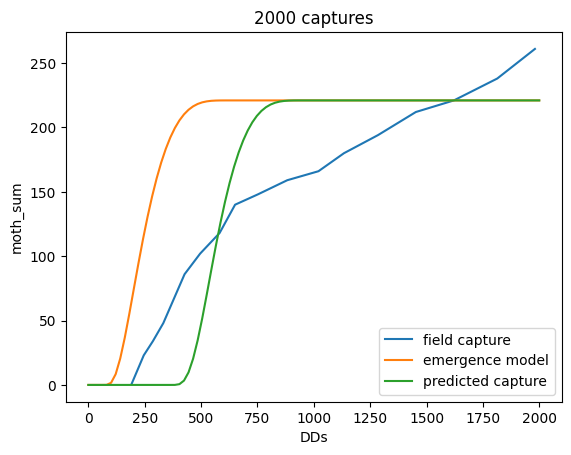

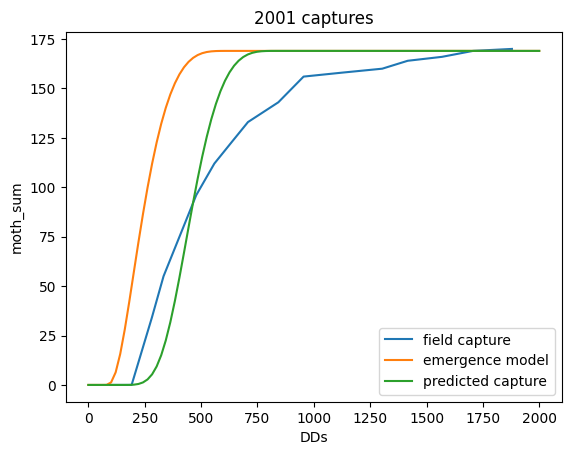

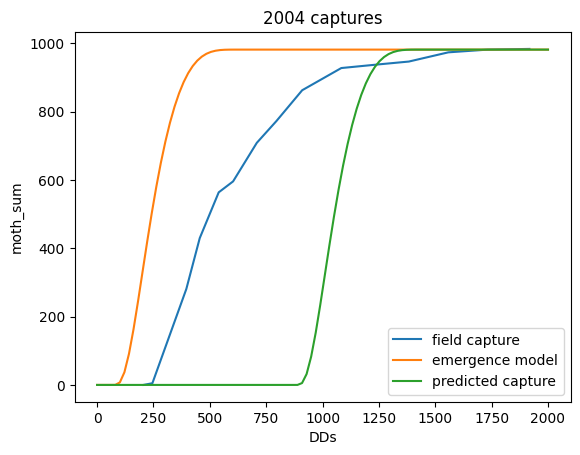

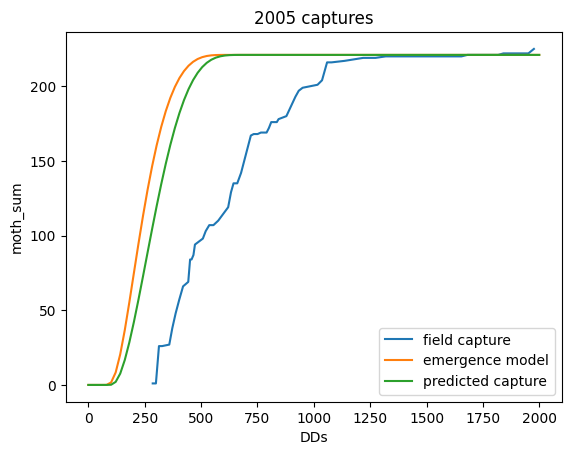

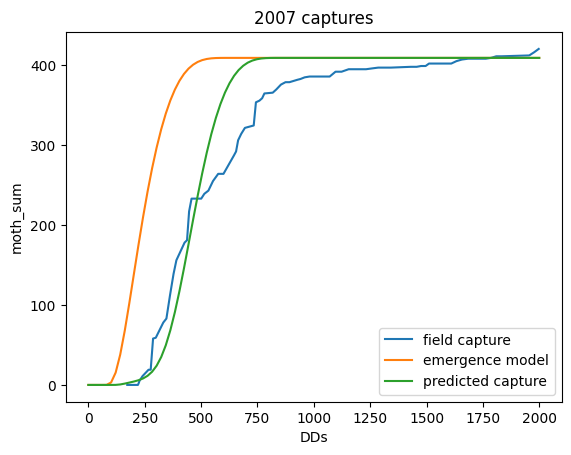

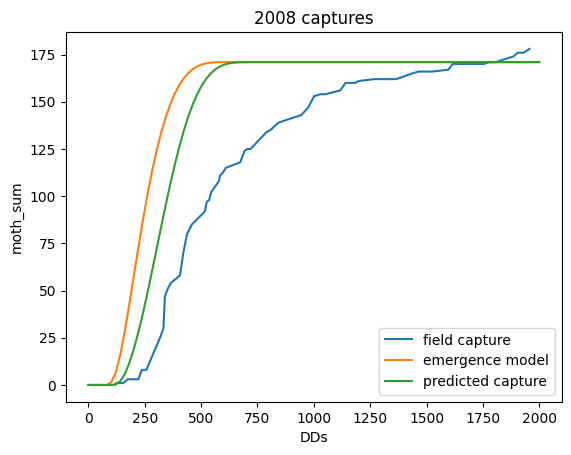

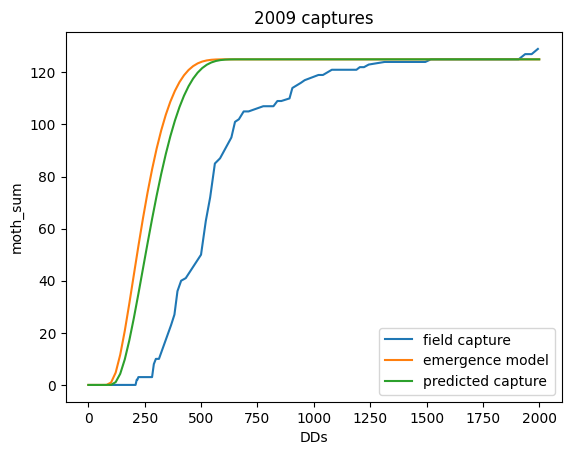

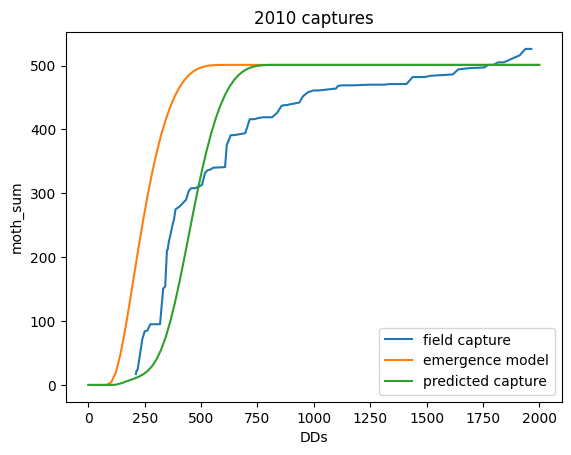

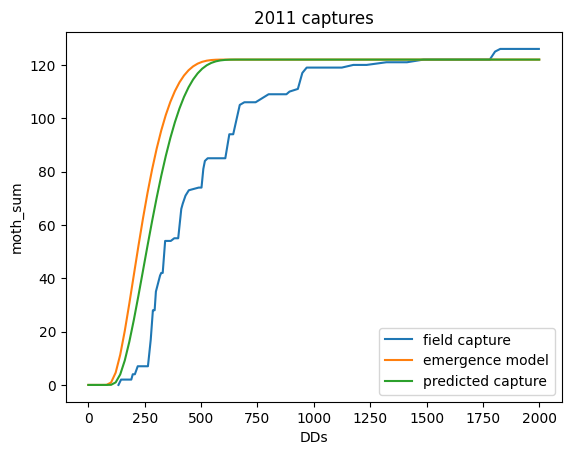

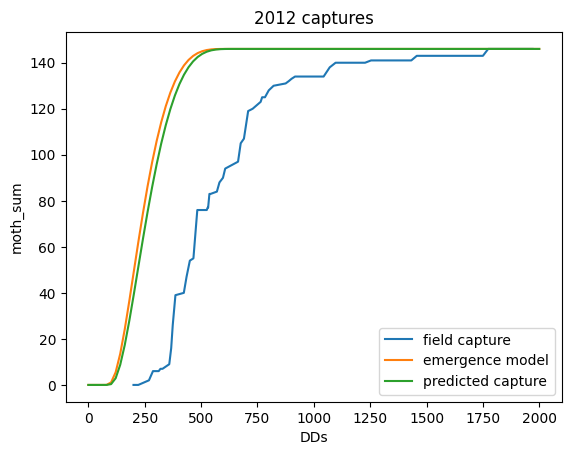

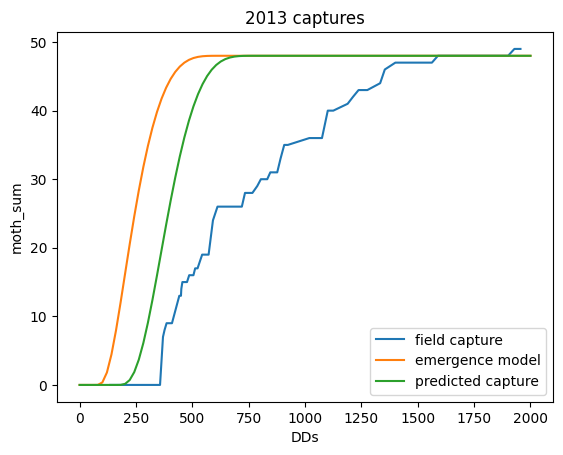

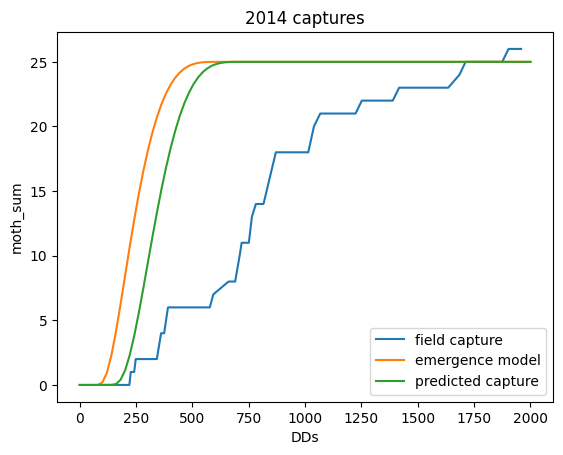

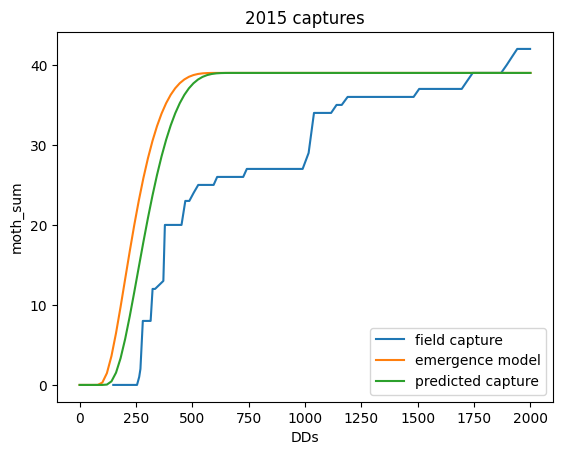

In [628]:
for n, agg in enumerate(aggs):
    agg = agg[agg.DDs < 2000]
    phenology_x = np.linspace(0,2000, 100)
    y_max = agg[agg.DDs < 1800].moth_sum.max()
    phenology_y = [jw_emergence(x, y_max) for x in phenology_x]
    adj_y = capture_prediction(phenology_x, efforts[n], y_max)
    year = int(agg.head(1).year.item())
    plt.figure()
    plt.title(f'{year} captures')
    sns.lineplot(data=agg, x='DDs', y='moth_sum', label='field capture')
    sns.lineplot(x=phenology_x, y=phenology_y, label='emergence model')
    sns.lineplot(x=phenology_x, y=adj_y, label='predicted capture')

Take these with a grain of salt, these are pretty much just crudely fit using a batch training with an arbitrarily decided limit for the maximum y.

### On-line prediction training for real-world use

In [845]:
def field_shift_error(effort, agg, max):
    x = agg.DDs
    y = agg.moth_sum
    differences = [np.abs(y.iloc[i]-capture_prediction(dd, effort, max))/(dd*max)*100 for i, dd in enumerate(x)]
    return np.sum(differences)
def predict(data, seeds, max) -> (float, float):
    predictions = []
    for seed in seeds:
        effort = seed
        effort_new = seed * 0.9
        error = field_shift_error(effort, agg, max)
        i = 0
        while i <= 20:
            error_new = field_shift_error(effort_new, agg, max)
            error_quotient = error_new / error
            #print(f'{error}, {error_new}, {error_quotient}')
            effort_new = effort_new * error_quotient
            effort = effort_new
            error = error_new
            if round(error_quotient,2) == 1.0:
                predictions.append((effort, error))
                break
            i += 1
    return predictions

prediction = predict(aggs[3], [0.15, 0.14, 0.13, 0.12, 0.11, 0.01, 0.009, 0.008, 0.007, 0.006, 0.005, 0.004, 0.003, 0.002, 0.001], 100)
prediction

[(0.13494378956318837, 5.6549123106647645),
 (0.12594488705027204, 5.653271511993406),
 (0.11694603523767248, 5.651416902408361),
 (0.10794724038803787, 5.6493004348167295),
 (0.09894851009913562, 5.6468579120066345),
 (0.008969616417635582, 5.451359385673085),
 (0.008069997695195109, 5.431167614575558),
 (0.007170697385792194, 5.406571199509951),
 (0.006271497476484438, 5.37597468711534),
 (0.005370385457233035, 5.33446177634443),
 (0.004470423364639774, 5.278854318109508),
 (0.003572019598029115, 5.20122062987828),
 (0.002671545540460917, 5.075018745184471),
 (0.0017756379882834785, 4.843985758379894),
 (0.0009134337738344124, 4.691455538497959)]

<Axes: title={'center': '2005 captures'}, xlabel='DDs', ylabel='moth_sum'>

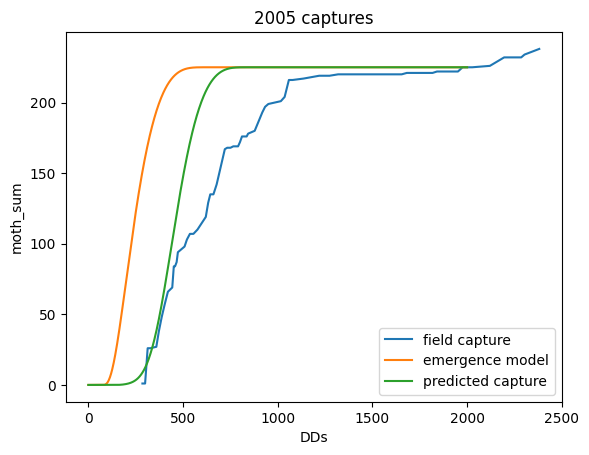

In [839]:
agg = aggs[3]
phenology_x = np.linspace(0,2000, 1000)
y_max = agg[agg.DDs < 2000].moth_sum.max()
phenology_y = [jw_emergence(x, y_max) for x in phenology_x]
adj_y = capture_prediction(phenology_x, 0.0015, y_max)
year = int(agg.head(1).year.item())
plt.figure()
plt.title(f'{year} captures')
sns.lineplot(data=agg, x='DDs', y='moth_sum', label='field capture')
sns.lineplot(x=phenology_x, y=phenology_y, label='emergence model')
sns.lineplot(x=phenology_x, y=adj_y, label='predicted capture')

In [572]:
aggs[4].head(20)

,julian,moths,var,traps,pr0,DDs,trap_group,moths_whole,year,moth_sum
332,114,0.000000,0.000000,3,1.000000,172.567891,12,0.0,2007.0,0.0
333,115,0.000000,0.000000,28,1.000000,179.692777,12,0.0,2007.0,0.0
334,116,0.000000,0.000000,78,1.000000,183.145276,12,0.0,2007.0,0.0
337,122,0.000000,0.000000,37,1.000000,219.810590,12,0.0,2007.0,0.0
338,123,0.039216,0.078431,51,0.975339,223.104048,12,2.0,2007.0,2.0
339,124,0.030612,0.029981,98,0.000000,226.767875,12,3.0,2007.0,5.0
340,126,0.075949,0.096722,79,0.793942,240.326598,12,6.0,2007.0,11.0
341,128,0.137931,0.857834,58,0.907323,267.075226,12,8.0,2007.0,19.0
342,129,0.000000,0.000000,42,1.000000,276.580233,12,0.0,2007.0,19.0
343,130,0.336207,2.277286,116,0.000000,287.114806,12,39.0,2007.0,58.0


In [581]:
capture_prediction(287, 0.01, 1000)

93.44482092842816